# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>

## Логистическая регрессия

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set_theme(style='dark', font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

### 1.  Cкачаем [датасет](https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate) о предсказании пульсаров.

Пульсары &mdash; это космические объекты, излучающие в различных диапазонах длины волны. Согласно современным астрофизическим теориям, пульсары представляют собой вращающиеся нейтронные звезды, обладающие магнитным полем, наклоненным относительно оси вращения.

Пульсары представляют значительный научный интерес. Поэтому есть потребность в автоматической идентификации интересных объектов для ускорения процесса изучения. На практике почти все обнаружения вызваны радиочастотными помехами и шумом, что затрудняет поиск достоверных сигналов. В последнее время для автоматического обнаружения пульсаров начали применять машинное обучение. Актуальная задача сегодня &mdash; бинарная классификация объектов-кандидатов на предмет того, являются ли они пульсарами.

В используемом датасете есть как примеры ложных обнаружений, так и примеры реальных пульсаров, подтвержденные учеными. Данные получены в результате [The High Time Resolution Universe Pulsar Survey I](https://arxiv.org/abs/1006.5744).

Мы будем работать только с файлом `pulsar_data_train.csv`.

In [22]:
data = pd.read_csv("pulsar_data_train.csv")
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


Сигнал от пульсаров представляет собой периодические импульсы.

Для описания объекта используется integrated profile (интегральный профиль) &mdash; агрегирование сигнала за разные периоды вращения (<a target="_blank" href="http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf">ссылка</a>, слайд 11). У всех пульсаров разные интегральные профили, и обычно эта характеристика мало меняется во времени.
В данном датасете интегральный профиль также усреднен по частоте.

Кроме того, импульс приходит в разное время на разных частотах. Задержка от частоты к частоте вызвана наличием ионизированной межзвездной среды и называется дисперсией. Не путать с дисперсией в теории вероятностей.

С дисперсией связана еще одна характеристика объекта &mdash; DM-SNR кривая. Подробнее о ней можно почитать <a target="_blank" href="https://arxiv.org/pdf/1005.5068.pdf#:~:text=period-DM%20diagram%3B%20good%20agreement,pulsars%20in%20their%20candidate%20plots.)">в специализированных материалах</a>.

Обе характеристики, integrated profile и DM-SNR кривая, представляют собой одномерные функции.
При создании датасета значения функций были посчитаны в конечном количестве $n$ точек.
Фактически, были получены реализации выборки двух случайных величин.

Пусть $P = (p_1, \ldots p_n)$ &mdash; массив значений integrated profile.
Для него можно посчитать следующие величины:

1.   Выборочное среднее $\bar p = \frac{1}{n}\sum \limits_{i=1}^n p_i$;
2.   Выборочное стандартное отклонение $\sqrt{\frac{1}{n}\sum \limits_{i=1}^n (p_i - \bar p)^2}$;
3. Выборочный коэффициент асимметрии (skewness);
4. Выборочный коэффициент эксцесса (kurtosis).

Для $D = (d_1, \ldots d_n)$, массива значений DM-SNR, аналогично.

Именно эти значения по массивам $P$ и $D$ являются признаками в данном датасете.

Про коэффициенты эксцесса и асимметрии можно посмотреть <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0">здесь</a> и <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B0%D1%81%D0%B8%D0%BC%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B8">здесь</a>, формулы для выборочных коэффициентов асимметрии и эксцесса можно найти в английской версии этих статей.

<a target="_blank" href="https://arxiv.org/pdf/1603.05166.pdf">Статья</a> с подробным описанием процесса генерации данных.










In [23]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


### 2. Предобработаем данные.

В этом датасете в некоторых столбцах есть пропуски в данных. Об этом говорит то, что значение Non-Null Count в таблице выше не равно количеству строк для некоторых столбцов. Чтобы не усложнять себе жизнь, пока просто не будем брать эти столбцы для анализа.

Посчитайем число пропусков в каждой колонке:

In [25]:
data.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

Удалите все соответствующие строчки:

In [29]:
data = data.dropna()

Теперь возьмем только некоторые столбцы в качестве независимых переменных и выделим зависимую. Столбец `target_class` отвечает за целевую переменную — индикатор того, является ли объект пульсаром.

In [35]:
needed_columns = [' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve']  # Используем только эти столбцы

X = data[needed_columns]
y = data["target_class"]

## 3. Графики

Проведем визуальный анализ данных. Построим оценки плотности по каждому признаку отдельно для каждого класса. Какие признаки лучше всего разделяют классы? Как это отразится на результатах модели?

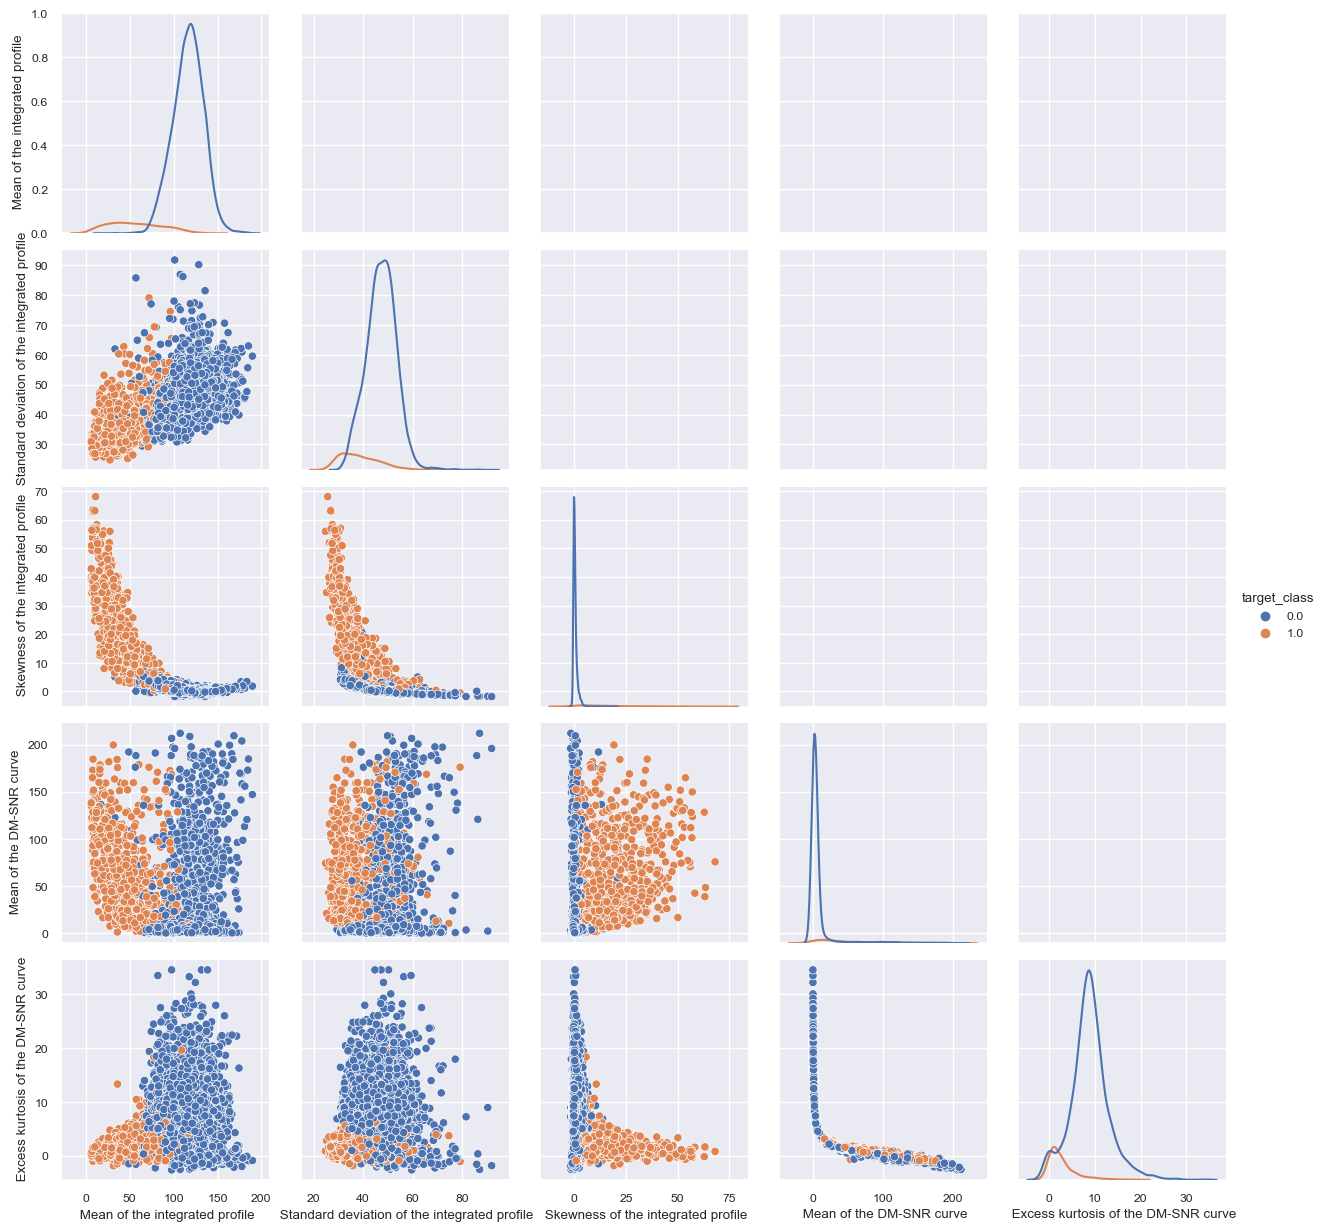

In [36]:
sns.set_theme(font_scale=0.8)

plot = sns.PairGrid(data, x_vars=needed_columns, y_vars=needed_columns, hue="target_class", diag_sharey=False)

plot.map_diag(sns.kdeplot)
plot.map_lower(sns.scatterplot)
plot.add_legend()

**Ответ:**

### 4. Разделим датасет и трансформируем данные

Добавьте  свободный член, присоединив столбец из единиц к `X`. Случайно разделите выборку на обучающую и тестовую части в соотношении 4:1.

In [39]:
X["intercept"] = np.ones((X.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

У признаков должен быть одинаковый масштаб. Преобразуйте датасет соответствующим образом.

In [40]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### 5. Обучим модель

Создайте и обучите логистическую регрессию. `fit_intercept` укажите `True`.

In [42]:
model = LogisticRegression(fit_intercept=True)

model.fit(X_train, y_train)

LogisticRegression()

Напечатайте коэффициенты модели. О чём говорят знаки `+` и `-`? Почему коэффициент, отвечающий за единичный столбец, равен нулю?

In [43]:
model.coef_, model.intercept_

(array([[-1.46324697,  0.52265651,  3.07670363, -0.37536413, -1.35038179,
          0.        ]]),
 array([-3.64979389]))

**Выводы:** "+" указывает на то, что увеличение данного признака увеличивает вероятность принадлежности к положительному классу. Для "-" наоборот, уменьшает. 

### 6. Проверим качество модели

Для  объектов из тестовой выборки оцените вероятность того, что это пульсар, при помощи метода [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Выведите эти значения, а также итоговые предсказания модели методом `predict`

In [47]:
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

y_pred_proba, y_pred

(array([[0.95920199, 0.04079801],
        [0.95537927, 0.04462073],
        [0.95976929, 0.04023071],
        ...,
        [0.99865184, 0.00134816],
        [0.89298567, 0.10701433],
        [0.99841907, 0.00158093]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

Теперь проверим качество нашей модели. Посчитайте его на тестовой выборке при помощи метрики Accuracy, показывающей долю правильных предсказаний:
$$
    Accuracy(y, \widehat{y}) = \frac{1}{n}\sum^{n-1}_{i = 0} I\{\widehat{y_i} = y_i\}
$$

In [45]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_test))

0.9773584905660377


Другими важными метриками для оценки качества модели являются precision, recall и F1. Precision показывает точность нашей модели, то есть долю правильно классифицированных объектов из всех, которым был присвоен первый класс. Recall - это полнота модели, то есть доля правильно классифицированных объектов из всех. F1 суммирует результаты этих двух метрик, считая их среднее гармоническое. Чуть подробнее можно прочитать про эти величины в [статье](https://habr.com/ru/articles/661119/).

<img width=450 src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png">

Посчитайте все три метрики для вашей модели. Сделайте выводы о качестве предсказаний.

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"precision:\t{precision_score(y_pred, y_test)}\nrecall:\t\t{recall_score(y_pred, y_test)}\nf1:\t\t{f1_score(y_pred, y_test)}")

precision:	0.7730061349693251
recall:		0.9618320610687023
f1:		0.8571428571428571


**Выводы:** Precision несколько меньше, чем recall. Метрика f1 учитывает обе предыдущие, так является средним гармоническим, по ней можно судить о качестве модели в целом.